In [8]:
cd /Users/Liangqiaohao/Downloads/PV Lab/2020/March/Learning project/ARES

/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/ARES


In [9]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy
import random

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [10]:
dataset = pd.read_csv(r'/Users/Liangqiaohao/Downloads/PV Lab/2020/March/Learning project/ARES/(Use this)2019-11-21.csv')
X = dataset.iloc[:,0:5]
X

,Prime Delay,Print Speed,X Offset Correction,Y Offset Correction,Score
0,0.000000,1.000000,0.000000,0.000000,0.339554
1,2.500000,3.000000,0.100000,0.100000,0.000000
2,5.000000,5.000000,-0.100000,-0.100000,0.218576
3,0.000000,0.999931,0.000006,0.000025,0.368919
4,0.000000,5.070133,0.225151,1.000000,0.000000
...,...,...,...,...,...
95,0.742365,1.714610,-0.380317,-0.416497,0.829756
96,0.000000,1.585934,-0.337143,-0.372811,0.922120
97,0.000000,1.568030,-0.335316,-0.365804,0.901296
98,0.000000,1.558826,-0.349834,-0.328645,0.936549


In [11]:
# i put negative sign here because default BO is for minimization
X['Score'] = -dataset.iloc[:,4].values

In [12]:
X_run = X.groupby(['Prime Delay', 'Print Speed', 'X Offset Correction', 'Y Offset Correction'])['Score'].agg(lambda x: x.unique().mean())
X_run = (X_run.to_frame()).reset_index()
X_run

,Prime Delay,Print Speed,X Offset Correction,Y Offset Correction,Score
0,0.0,0.1,-0.837284,-1.000000,-0.138480
1,0.0,0.1,-0.562308,-1.000000,-0.553860
2,0.0,0.1,-0.399772,1.000000,-0.237950
3,0.0,0.1,-0.383307,-0.025953,-0.529015
4,0.0,0.1,-0.263441,-1.000000,-0.444846
...,...,...,...,...,...
95,5.0,10.0,-0.453751,-1.000000,-0.649364
96,5.0,10.0,-0.392564,-1.000000,-0.641716
97,5.0,10.0,-0.030374,-1.000000,-0.394429
98,5.0,10.0,1.000000,-1.000000,0.000000


In [13]:
features = ['Prime Delay', 'Print Speed', 'X Offset Correction', 'Y Offset Correction']
X_feature = X_run[['Prime Delay', 'Print Speed', 'X Offset Correction', 'Y Offset Correction']].values

y = np.array(X_run['Score'].values)

raw_mean = np.mean(y)
raw_std = np.std(y)

In [15]:
y = (y - raw_mean) / raw_std

In [17]:
n_initial = 2
n_top = int(math.ceil(len(y) * 0.05))

top_indices = list(X_run.sort_values('Score').head(n_top).index)

In [18]:
top_indices

[13, 18, 15, 21, 17]

In [20]:
nsteps = len(X_run)
nsteps

100

In [23]:
cd /Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/ARES

/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/ARES


In [24]:
x_GP_EI = np.load('ARES_STD_GP_EI_master.npy', allow_pickle = True)
x_GP_LCB11 = np.load('ARES_STD_GP_LCB11_master.npy', allow_pickle = True)



x_RF_EI = np.load('ARES_STD_RF_EI_master.npy', allow_pickle = True)
x_RF_LCB11 = np.load('ARES_STD_RF_LCB11_master.npy', allow_pickle = True)
x_RF_LCB10 = np.load('ARES_STD_RF_LCB10_master.npy', allow_pickle = True)
x_RF_LCB01 = np.load('ARES_STD_RF_LCB01_master.npy', allow_pickle = True)
x_RF_LCB7525 = np.load('ARES_STD_RF_LCB7525_master.npy', allow_pickle = True)






In [25]:
def ALM_de(x):
#     rows
    n_runs = len(x)
#     columns
#     n_eval = int(np.round(len(x[0])*0.8))
    n_eval = len(x[0])
    
    
    l_f = []
    
    for i in np.arange(n_runs):
        i_row = x[i]
        
        
        f_ = []
    
        y_best = 10**15
        list_f = []
        for j in np.arange(n_eval):
            y_thisround = i_row[j]

            f = np.sum(y_thisround <= np.array(i_row[j+1:])) / len(np.array(i_row[j+1:]))
            f_.append(f)
            y_best = min(y_thisround, y_best)
#         print(f_)        
        l_f.append(f_)
    
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    
    l_f =  np.array(l_f)
    for j in np.arange(n_eval):
        j_column = l_f[:,j]
        
        mean_[j] = np.mean(j_column)
        median_[j] = np.median(j_column)
        std_[j] = np.std(j_column)
        six_[j] = np.quantile(j_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[j] = np.quantile(j_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    mean_ = 2*np.array(mean_) - 1
    std_ = 2*np.array(std_) - 1
    median_ = 2*np.array(median_) - 1
    six_ = 2*np.array(six_) - 1
    nintyfour_ = 2*np.array(nintyfour_) - 1
    return np.array(mean_), np.array(std_), np.array(median_), np.array(six_), np.array(nintyfour_)
        
        
        
        
        
    

Text(0.5, 0, 'n_eval')

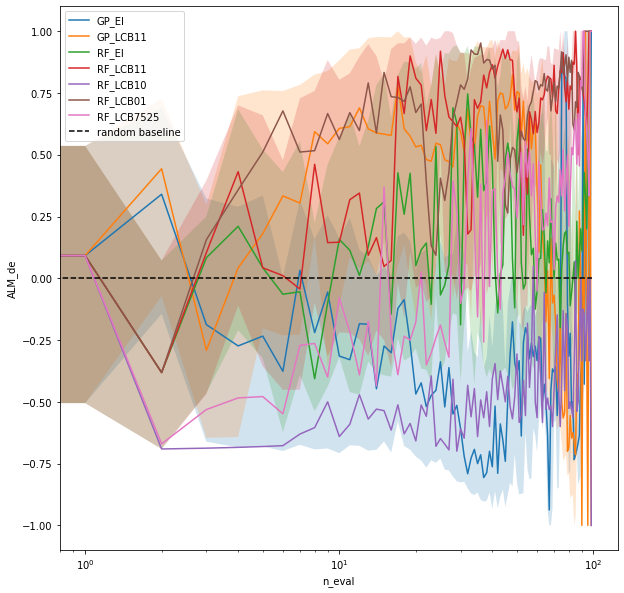

In [26]:
ALM_de_GP_EI = ALM_de(x_GP_EI[2])
ALM_de_GP_LCB11 = ALM_de(x_GP_LCB11[2])


ALM_de_RF_EI = ALM_de(x_RF_EI[2])
ALM_de_RF_LCB11 = ALM_de(x_RF_LCB11[2])

ALM_de_RF_LCB10 = ALM_de(x_RF_LCB10[2])
ALM_de_RF_LCB01 = ALM_de(x_RF_LCB01[2])
ALM_de_RF_LCB7525 = ALM_de(x_RF_LCB7525[2])



fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


ax0.plot(ALM_de_GP_EI[2], label = 'GP_EI')
ax0.fill_between(np.arange(len(ALM_de_GP_EI[2])), ALM_de_GP_EI[3], ALM_de_GP_EI[4], alpha=0.2)

ax0.plot(ALM_de_GP_LCB11[2], label = 'GP_LCB11')
ax0.fill_between(np.arange(len(ALM_de_GP_LCB11[2])), ALM_de_GP_LCB11[3], ALM_de_GP_LCB11[4], alpha=0.2)


ax0.plot(ALM_de_RF_EI[2], label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_de_RF_EI[2])), ALM_de_RF_EI[3], ALM_de_RF_EI[4], alpha=0.2)

ax0.plot(ALM_de_RF_LCB11[2], label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_de_RF_LCB11[2])), ALM_de_RF_LCB11[3], ALM_de_RF_LCB11[4], alpha=0.2)


ax0.plot(ALM_de_RF_LCB10[2], label = 'RF_LCB10')
ax0.plot(ALM_de_RF_LCB01[2], label = 'RF_LCB01')
ax0.plot(ALM_de_RF_LCB7525[2], label = 'RF_LCB7525')


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.zeros(nsteps),'--',color='black',label='random baseline')

ax0.legend()
ax0.set_xscale('log')
ax0.set_ylabel('ALM_de')
ax0.set_xlabel('n_eval')

In [27]:
ALM_de_RF_LCB11[2]

array([ 0.25252525,  0.09183673, -0.3814433 ,  0.10416667,  0.43157895,
        0.04255319,  0.01075269, -0.04347826,  0.46153846,  0.14444444,
        0.14606742,  0.31818182,  0.34482759,  0.09302326,  0.16470588,
        0.04761905,  0.07228916,  0.81707317,  0.66666667,  0.9       ,
        0.81012658,  0.78205128,  0.5974026 ,  0.72368421,  0.58666667,
        0.91891892,  0.73972603,  0.65277778,  0.63380282,  0.61428571,
        0.65217391,  0.55882353,  0.17910448,  0.1969697 ,  0.72307692,
        0.6875    ,  0.71428571,  0.82258065,  0.7704918 ,  0.83333333,
        0.86440678,  0.81034483,  0.85964912,  0.89285714,  0.92727273,
        0.88888889,  0.9245283 ,  0.88461538,  0.88235294,  0.74      ,
        0.67346939,  0.72916667,  0.40425532,  0.17391304,  0.46666667,
        0.34090909,  0.6744186 ,  0.64285714,  0.58536585,  0.675     ,
        0.58974359,  0.63157895,  0.72972973,  0.72222222,  0.74285714,
        0.79411765,  0.81818182,  0.8125    ,  0.80645161,  0.73

In [28]:
# http://www.rsc.org/suppdata/c9/sc/c9sc05999g/c9sc05999g1.pdf
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
#     print(A)
        
    return E / M, cA

In [29]:
seed_list = [5782, 5776, 9975, 4569, 8020, 363, 9656, 992, 348, 6048, 4114, 7476, 4892, 9710, 9854, 5243, 
             2906, 5963, 3035, 5122, 9758, 4327, 4921, 6179, 1718, 441, 9326, 2153, 5079, 8192, 3646, 4413, 
             3910, 5370, 3070, 7130, 1589, 1668, 9842, 5275, 5468, 3677, 7183, 2773, 1309, 5516, 3572, 9312, 
             7390, 4433, 3686, 1981, 555, 8677, 3126, 5163, 9418, 3007, 4564, 5572, 1401, 5657, 9658, 2124, 
             6902, 4783, 8493, 4442, 7613, 5674, 6830, 4757, 6877, 9311, 6709, 582, 6770, 2555, 3269, 76, 
             7820, 8358, 7116, 9156, 3638, 529, 7482, 8503, 4735, 8910, 5588, 3726, 1115, 9644, 4702, 1966, 
             4006, 738, 575, 8393]

def aggregation_(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
#     print(agg_list)    
    return agg_list


In [30]:
def avg_(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 50
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    assert n_sets * n_fold == len(l_avg_runs)
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_), np.array(low_q), np.array(high_q)


In [31]:
def ALM_all(x):
    
    n_eval = len(x[0])
    
    x_ = [[] for i in np.arange(len(x))]
    
    for j in np.arange(len(x)):
        for i in np.arange(n_eval):
            x_[j].append(x[j][i] / n_top)
        
    return x_

In [32]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

TopPercent = 3

i_ = TopPercent

ALM_all_GP_LCB11 = avg_(ALM_all(x_GP_LCB11[i_]))
ALM_all_GP_EI = avg_(ALM_all(x_GP_EI[i_]))


ALM_all_RF_LCB11 = avg_(ALM_all(x_RF_LCB11[i_]))
ALM_all_RF_EI = avg_(ALM_all(x_RF_EI[i_]))

                        
ALM_all_RF_LCB10 = avg_(ALM_all(x_RF_LCB10[i_]))
ALM_all_RF_LCB01 = avg_(ALM_all(x_RF_LCB01[i_]))
ALM_all_RF_LCB7525 = avg_(ALM_all(x_RF_LCB7525[i_]))



Text(0.5, 0, 'n_eval')

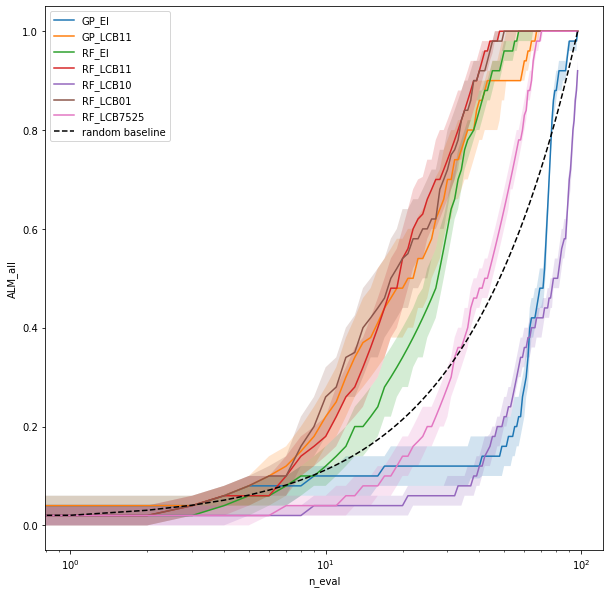

In [33]:
# np.array(median_), np.array(low_q), np.array(high_q)


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


ax0.plot(np.round(ALM_all_GP_EI[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP_EI')
ax0.fill_between(np.arange(len(ALM_all_GP_EI[0])), np.round(ALM_all_GP_EI[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_GP_EI[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_GP_LCB11[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP_LCB11')
ax0.fill_between(np.arange(len(ALM_all_GP_LCB11[0])), np.round(ALM_all_GP_LCB11[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_GP_LCB11[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_RF_EI[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_all_RF_EI[0])), np.round(ALM_all_RF_EI[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_RF_EI[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_RF_LCB11[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB11[0])), np.round(ALM_all_RF_LCB11[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_RF_LCB11[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_RF_LCB10[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF_LCB10')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB10[0])), np.round(ALM_all_RF_LCB10[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_RF_LCB10[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_RF_LCB01[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF_LCB01')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB01[0])), np.round(ALM_all_RF_LCB01[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_RF_LCB01[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)

ax0.plot(np.round(ALM_all_RF_LCB7525[0].astype(np.double) / 0.005, 0) * 0.005, label = 'RF_LCB7525')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB7525[0])), np.round(ALM_all_RF_LCB7525[1].astype(np.double) / 0.005, 0) * 0.005, np.round(ALM_all_RF_LCB7525[2].astype(np.double) / 0.005, 0) * 0.005, alpha=0.2)



# ax0.plot(np.arange(len(ALM_all_RF_LCB11[0])), P_rand(len(ALM_all_RF_LCB11[0]))[0],'--',color='black',label='random baseline')
ax0.plot(np.arange(len(ALM_all_RF_LCB11[0])), P_rand(len(ALM_all_RF_LCB11[0]))[0],'--',color='black',label='random baseline')



ax0.legend()
# ax0.set_ylabel('loss')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, 500])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
ax0.set_ylabel('ALM_all')
ax0.set_xlabel('n_eval')



In [34]:
def EF(x):
    
    n_eval = len(x)

    ALM_ALL_RS = P_rand(n_eval)[0]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ALL_RS[j])
        
    return l_EF
  

def AF(x):
    
    n_eval = len(x)

#     ALM_RS = P_rand(n_eval)[0]
    ALM_RS = list(np.round(P_rand(len(ALM_all_RF_LCB11[0]))[0].astype(np.double) / 0.005, 0) * 0.005)
    l_ALM = []
    l_AF = []
    
    x = list(np.round(x.astype(np.double) / 0.005, 0) * 0.005)
    
    ALM_linspace = np.arange(0, 1.005, 0.005)
#     print(len(ALM_RS))
#     print(len(x))
    
    pointer_x = 0
    pointer_rs = 0
    for t in ALM_linspace:
        if t in x and t in ALM_RS:
            n_x = 0
            n_rs = 0
            while pointer_x < len(x):
                if x[pointer_x] == t:
                    pointer_x += 1
                    n_x = pointer_x
                    break
                else:
                    pointer_x += 1

            while pointer_rs < len(ALM_RS):
                if ALM_RS[pointer_rs] == t:
                    pointer_rs += 1
                    n_rs = pointer_rs
                    break
                else:
                    pointer_rs += 1
        
            l_ALM.append(t)
#             print(t, n_rs, n_x)
            AF = n_rs / n_x
            l_AF.append(AF)  
        
    return l_ALM, l_AF                                 



In [35]:
from scipy.interpolate import splrep

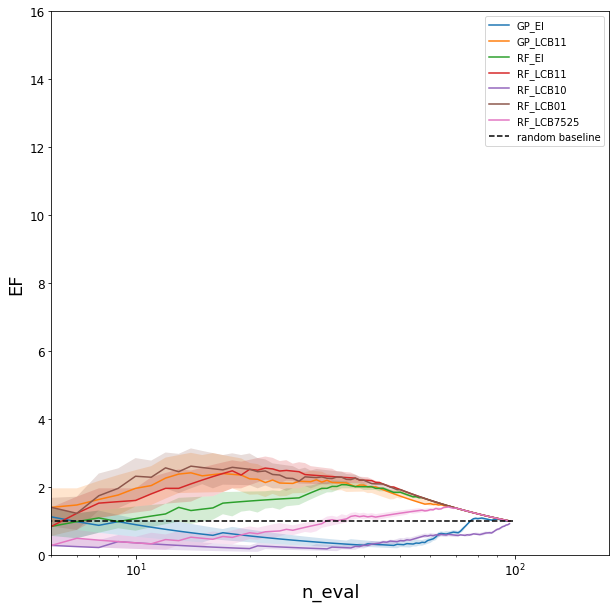

In [36]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(EF(ALM_all_GP_EI[0]), label = 'GP_EI')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_EI[0]))), EF(ALM_all_GP_EI[1]), EF(ALM_all_GP_EI[2]), alpha=0.2)

ax0.plot(EF(ALM_all_GP_LCB11[0]), label = 'GP_LCB11')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_LCB11[0]))), EF(ALM_all_GP_LCB11[1]), EF(ALM_all_GP_LCB11[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_EI[0]), label = 'RF_EI')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_EI[0]))), EF(ALM_all_RF_EI[1]), EF(ALM_all_RF_EI[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB11[0]), label = 'RF_LCB11')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB11[0]))), EF(ALM_all_RF_LCB11[1]), EF(ALM_all_RF_LCB11[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB10[0]), label = 'RF_LCB10')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB10[0]))), EF(ALM_all_RF_LCB10[1]), EF(ALM_all_RF_LCB10[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB01[0]), label = 'RF_LCB01')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB01[0]))), EF(ALM_all_RF_LCB01[1]), EF(ALM_all_RF_LCB01[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB7525[0]), label = 'RF_LCB7525')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB7525[0]))), EF(ALM_all_RF_LCB7525[1]), EF(ALM_all_RF_LCB7525[2]), alpha=0.2)


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.ones(nsteps),'--',color='black',label='random baseline')        

ax0.legend()
ax0.set_ylabel('EF', fontsize=18)
ax0.tick_params(axis='y', labelsize=12)

ax0.set_xlabel('n_eval', fontsize=18)
ax0.tick_params(axis='x', labelsize=12)
# ax0.set_title('median')
ax0.set_xlim([6, 178])
ax0.set_ylim([0, 16])
ax0.set_xscale('log')
# ax0.set_yscale('log')
        
    

In [37]:
from scipy.interpolate import interp1d

In [38]:
def AF_interp1d(ALM_all):
    f_med = interp1d(AF(ALM_all[0])[0], AF(ALM_all[0])[1], kind = 'linear', fill_value='extrapolate')
    xx_ = np.linspace(min(AF(ALM_all[0])[0]), 1, 201 - int(min(AF(ALM_all[0])[0])/0.005))
    f_low = interp1d(AF(ALM_all[1])[0], AF(ALM_all[1])[1], kind = 'linear', fill_value='extrapolate')
    f_high = interp1d(AF(ALM_all[2])[0], AF(ALM_all[2])[1], kind = 'linear', fill_value='extrapolate')   
    return xx_, f_med, f_low, f_high
    

Text(0.5, 0, 'ALM_all')

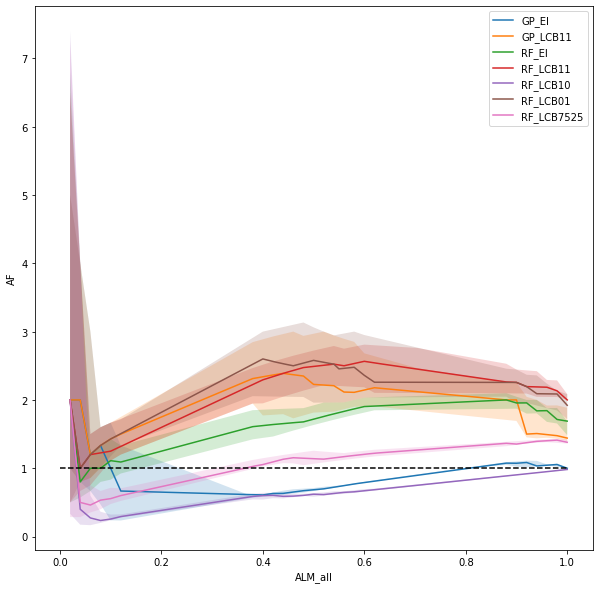

In [39]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


xx_GP_EI, f_med_GP_EI, f_low_GP_EI, f_high_GP_EI = AF_interp1d(ALM_all_GP_EI)
ax0.plot(xx_GP_EI, f_med_GP_EI(xx_GP_EI), label = 'GP_EI')
ax0.fill_between(xx_GP_EI, f_low_GP_EI(xx_GP_EI), f_high_GP_EI(xx_GP_EI), alpha=0.2)

xx_GP_LCB11, f_med_GP_LCB11, f_low_GP_LCB11, f_high_GP_LCB11 = AF_interp1d(ALM_all_GP_LCB11)
ax0.plot(xx_GP_LCB11, f_med_GP_LCB11(xx_GP_LCB11), label = 'GP_LCB11')
ax0.fill_between(xx_GP_LCB11, f_low_GP_LCB11(xx_GP_LCB11), f_high_GP_LCB11(xx_GP_LCB11), alpha=0.2)

xx_RF_EI, f_med_RF_EI, f_low_RF_EI, f_high_RF_EI = AF_interp1d(ALM_all_RF_EI)
ax0.plot(xx_RF_EI, f_med_RF_EI(xx_RF_EI), label = 'RF_EI')
ax0.fill_between(xx_RF_EI, f_low_RF_EI(xx_RF_EI), f_high_RF_EI(xx_RF_EI), alpha=0.2)

xx_RF_LCB11, f_med_RF_LCB11, f_low_RF_LCB11, f_high_RF_LCB11 = AF_interp1d(ALM_all_RF_LCB11)
ax0.plot(xx_RF_LCB11, f_med_RF_LCB11(xx_RF_LCB11), label = 'RF_LCB11')
ax0.fill_between(xx_RF_LCB11, f_low_RF_LCB11(xx_RF_LCB11), f_high_RF_LCB11(xx_RF_LCB11), alpha=0.2)

xx_RF_LCB10, f_med_RF_LCB10, f_low_RF_LCB10, f_high_RF_LCB10 = AF_interp1d(ALM_all_RF_LCB10)
ax0.plot(xx_RF_LCB10, f_med_RF_LCB10(xx_RF_LCB10), label = 'RF_LCB10')
ax0.fill_between(xx_RF_LCB10, f_low_RF_LCB10(xx_RF_LCB10), f_high_RF_LCB10(xx_RF_LCB10), alpha=0.2)

xx_RF_LCB01, f_med_RF_LCB01, f_low_RF_LCB01, f_high_RF_LCB01 = AF_interp1d(ALM_all_RF_LCB01)
ax0.plot(xx_RF_LCB01, f_med_RF_LCB01(xx_RF_LCB01), label = 'RF_LCB01')
ax0.fill_between(xx_RF_LCB01, f_low_RF_LCB01(xx_RF_LCB01), f_high_RF_LCB01(xx_RF_LCB01), alpha=0.2)

xx_RF_LCB7525, f_med_RF_LCB7525, f_low_RF_LCB7525, f_high_RF_LCB7525 = AF_interp1d(ALM_all_RF_LCB7525)
ax0.plot(xx_RF_LCB7525, f_med_RF_LCB7525(xx_RF_LCB7525), label = 'RF_LCB7525')
ax0.fill_between(xx_RF_LCB7525, f_low_RF_LCB7525(xx_RF_LCB7525), f_high_RF_LCB7525(xx_RF_LCB7525), alpha=0.2)


# ax0.plot(AF(ALM_all_RF_LCB10[0])[0], AF(ALM_all_RF_LCB10[0])[1], label = 'RF_LCB10')
# ax0.plot(AF(ALM_all_RF_LCB01[0])[0], AF(ALM_all_RF_LCB01[0])[1], label = 'RF_LCB01')
# ax0.plot(AF(ALM_all_RF_LCB7525[0])[0], AF(ALM_all_RF_LCB7525[0])[1], label = 'RF_LCB7525')

ax0.plot(np.linspace(0, 1, 176), np.ones(176),'--',color='black',label=None)        
        

ax0.legend()
ax0.set_ylabel('AF')
ax0.set_xlabel('ALM_all')
# ax0.set_title('median')
# ax0.set_xlim([8, nn])
# ax0.set_ylim([0.95, 5])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [40]:
def ALM_any(x, top_list):
    
    n_eval = len(x[0])
    
    assert n_eval > len(top_list)
    
    x_ = [[0 for m in np.arange(n_eval)] for n in np.arange(len(x))]
    
    for j in np.arange(len(x)):
        found = False
        for i in np.arange(n_eval):
            if found == False:
                if x[j][i] in top_list:
                    x_[j][i] = 1
                    found = True
                    
            else:
                x_[j][i] = 1
        
    return x_

In [41]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

index_ = 0

i_ = index_


ALM_any_GP_EI = avg_(ALM_any(x_GP_EI[i_], top_indices))
ALM_any_GP_LCB11 = avg_(ALM_any(x_GP_LCB11[i_], top_indices))

ALM_any_RF_EI = avg_(ALM_any(x_RF_EI[i_], top_indices))
ALM_any_RF_LCB11 = avg_(ALM_any(x_RF_LCB11[i_], top_indices))

ALM_any_RF_LCB10 = avg_(ALM_any(x_RF_LCB10[i_], top_indices))
ALM_any_RF_LCB01 = avg_(ALM_any(x_RF_LCB01[i_], top_indices))
ALM_any_RF_LCB7525 = avg_(ALM_any(x_RF_LCB7525[i_], top_indices))


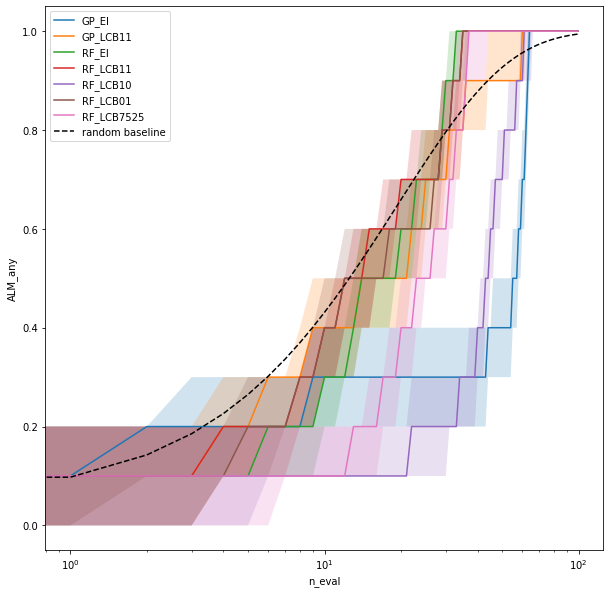

In [42]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(np.round(ALM_any_GP_EI[0].astype(np.double) / 0.1, 0) * 0.1, label = 'GP_EI')
ax0.fill_between(np.arange(len(ALM_any_GP_EI[0])), np.round(ALM_any_GP_EI[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_GP_EI[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_GP_LCB11[0].astype(np.double) / 0.1, 0) * 0.1, label = 'GP_LCB11')
ax0.fill_between(np.arange(len(ALM_any_GP_LCB11[0])), np.round(ALM_any_GP_LCB11[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_GP_LCB11[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_RF_EI[0].astype(np.double) / 0.1, 0) * 0.1, label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_any_RF_EI[0])), np.round(ALM_any_RF_EI[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_RF_EI[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_RF_LCB11[0].astype(np.double) / 0.1, 0) * 0.1, label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB11[0])), np.round(ALM_any_RF_LCB11[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_RF_LCB11[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_RF_LCB10[0].astype(np.double) / 0.1, 0) * 0.1, label = 'RF_LCB10')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB10[0])), np.round(ALM_any_RF_LCB10[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_RF_LCB10[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_RF_LCB01[0].astype(np.double) / 0.1, 0) * 0.1, label = 'RF_LCB01')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB11[0])), np.round(ALM_any_RF_LCB01[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_RF_LCB01[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)

ax0.plot(np.round(ALM_any_RF_LCB7525[0].astype(np.double) / 0.1, 0) * 0.1, label = 'RF_LCB7525')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB7525[0])), np.round(ALM_any_RF_LCB7525[1].astype(np.double) / 0.1, 0) * 0.1, np.round(ALM_any_RF_LCB7525[2].astype(np.double) / 0.1, 0) * 0.1, alpha=0.2)


ax0.plot(np.arange(len(ALM_any_GP_LCB11[0])), P_rand(len(ALM_any_GP_LCB11[0]))[1],'--',color='black',label='random baseline')    
        

ax0.legend()
ax0.set_ylabel('ALM_any')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([-10, nn+1000])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
# ax0.set_yscale('log')

In [118]:
ss = np.array([1,2,3,4,5])
aa = np.delete(ss, [0, 1, 4])
aa

array([3, 4])

In [148]:
def EF_any(x):
    
    n_eval = len(x)

    ALM_ANY_RS = P_rand(n_eval)[1]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ANY_RS[j])
        
    return l_EF
  

def AF_any(x):
    
    n_eval = len(x)

#     ALM_RS = P_rand(n_eval)[0]
    ALM_RS = P_rand(len(ALM_any_GP_LCB11[0]))[1]
    l_ALM = []
    l_AF = []
    
    
    ALM_linspace = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    n_rs = []
    for i in np.arange(len(ALM_linspace)):
        target = ALM_linspace[i]
        closest = np.argmin(np.abs(ALM_RS - target))
        n_rs.append(closest+1)
    n_rs = np.array(n_rs)    
        
    n_x = []
    for i in np.arange(len(ALM_linspace)):
        target = ALM_linspace[i]
        same_as_target = []
        for j in np.arange(len(x)):
            if x[j] == target:
                same_as_target.append(j+1)
#             print(same_as_target)
#         n_x.append(np.mean(np.array(same_as_target)))
        if len(same_as_target) != 0:
            n_x.append(np.min(np.array(same_as_target)))
        else:
            n_x.append(None)
    n_x = np.array(n_x)
            
    fix_index = []        
    for i in np.arange(len(n_x)):
        if n_x[i] == None:
            fix_index.append(i)
            
    n_rs = np.delete(n_rs, fix_index)
    n_x = np.delete(n_x, fix_index)
    l_ALM = np.delete(np.array(ALM_linspace), fix_index)

                
    assert len(n_rs) == len(n_x) == len(l_ALM)
    for i in np.arange(len(n_rs)):
        l_AF.append(n_rs[i] / n_x[i])
    
    print(n_rs)
    print(n_x)
   
    return l_ALM, l_AF   

In [141]:
def AF_any_interp1d(ALM_any):
    f_med = interp1d(AF_any(ALM_any[0])[0], AF_any(ALM_any[0])[1], kind = 'linear', fill_value='extrapolate')
    xx_ = np.linspace(0, 1, 11)
    f_low = interp1d(AF_any(ALM_any[1])[0], AF_any(ALM_any[1])[1], kind = 'linear', fill_value='extrapolate')
    f_high = interp1d(AF_any(ALM_any[2])[0], AF_any(ALM_any[2])[1], kind = 'linear', fill_value='extrapolate')   
    return xx_, f_med, f_low, f_high


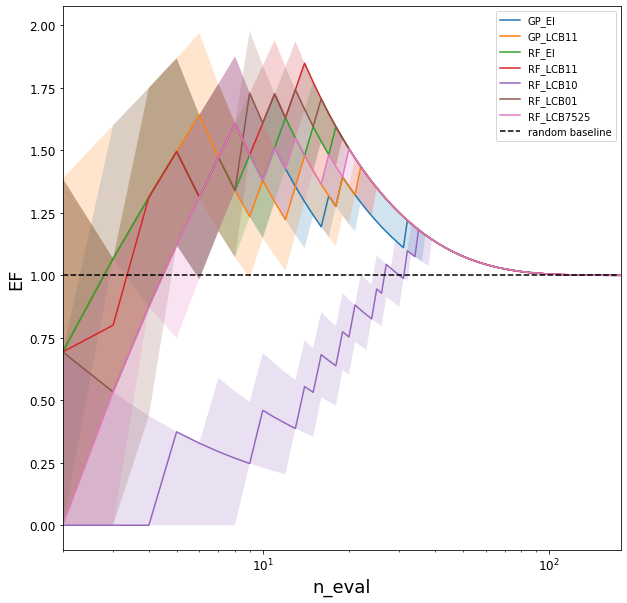

In [29]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(EF_any(ALM_any_GP_EI[0]), label = 'GP_EI')
ax0.fill_between(np.arange(len(EF_any(ALM_any_GP_EI[0]))), EF_any(ALM_any_GP_EI[1]), EF_any(ALM_any_GP_EI[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_GP_LCB11[0]), label = 'GP_LCB11')
ax0.fill_between(np.arange(len(EF_any(ALM_any_GP_LCB11[0]))), EF_any(ALM_any_GP_LCB11[1]), EF_any(ALM_any_GP_LCB11[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_RF_EI[0]), label = 'RF_EI')
ax0.fill_between(np.arange(len(EF_any(ALM_any_RF_EI[0]))), EF_any(ALM_any_RF_EI[1]), EF_any(ALM_any_RF_EI[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_RF_LCB11[0]), label = 'RF_LCB11')
ax0.fill_between(np.arange(len(EF_any(ALM_any_RF_LCB11[0]))), EF_any(ALM_any_RF_LCB11[1]), EF_any(ALM_any_RF_LCB11[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_RF_LCB10[0]), label = 'RF_LCB10')
ax0.fill_between(np.arange(len(EF_any(ALM_any_RF_LCB10[0]))), EF_any(ALM_any_RF_LCB10[1]), EF_any(ALM_any_RF_LCB10[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_RF_LCB01[0]), label = 'RF_LCB01')
ax0.fill_between(np.arange(len(EF_any(ALM_any_RF_LCB01[0]))), EF_any(ALM_any_RF_LCB01[1]), EF_any(ALM_any_RF_LCB01[2]), alpha=0.2)

ax0.plot(EF_any(ALM_any_RF_LCB7525[0]), label = 'RF_LCB7525')
ax0.fill_between(np.arange(len(EF_any(ALM_any_RF_LCB7525[0]))), EF_any(ALM_any_RF_LCB7525[1]), EF_any(ALM_any_RF_LCB7525[2]), alpha=0.2)


ax0.plot(np.linspace(0, 176, 176), np.ones(176),'--',color='black',label= 'random baseline')   

ax0.legend()
ax0.set_ylabel('EF', fontsize=18)
ax0.tick_params(axis='y', labelsize=12)

ax0.set_xlabel('n_eval', fontsize=18)
ax0.tick_params(axis='x', labelsize=12)
# ax0.set_title('median')
ax0.set_xlim([2, 178])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
# ax0.set_yscale('log')
        

In [150]:
P_rand(len(ALM_any_GP_LCB11[0]))[1]

array([0.05056179775280899, 0.09856710011362202, 0.14414516808540517,
       0.18741872700243525, 0.2285042969854582, 0.2675125066884407,
       0.3045483911817218, 0.3397116747736572, 0.3730970395322925,
       0.40479438023009795, 0.43488904639823905, 0.4634620721421483,
       0.4905903943372082, 0.5163470597920684, 0.5408014219374132,
       0.5640193275697912, 0.5860632941533411, 0.6069926781568239,
       0.6268638348792317, 0.6457302701943267, 0.6636427846227034,
       0.6806496101193084, 0.6967965399447366, 0.7121270519700027,
       0.7266824257468003, 0.740501853658479, 0.7536225464510278,
       0.766079833428223, 0.7779072575807285, 0.7891366659052984,
       0.7997982951572777, 0.809920853267303, 0.8195315966414282,
       0.8286564035528167, 0.837319843822618, 0.8455452449776542,
       0.8533547550630537, 0.8607694022789667, 0.8678091516019403,
       0.8744929585434152, 0.8808388201900965, 0.8868638236636309,
       0.8925841921300766, 0.8980153284830502, 0.90317185681

In [151]:
ALM_any_GP_EI[1]

array([0. , 0. , 0. , 0.2, 0.2, 0.3, 0.3, 0.4, 0.5, 0.5, 0.5, 0.6, 0.6,
       0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [152]:
AF_any(ALM_any_GP_EI[0])

[  1   2   4   7  10  13  18  23  31  44 178]
[ 1  3  4  5  6  8  9 12 18 20 33]


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [1.0,
  0.6666666666666666,
  1.0,
  1.4,
  1.6666666666666667,
  1.625,
  2.0,
  1.9166666666666667,
  1.7222222222222223,
  2.2,
  5.393939393939394])

In [147]:
f_low_GP_EI(xx_GP_EI)

array([1.        , 1.        , 1.        , 1.16666667, 1.25      ,
       1.44444444, 1.5       , 1.4375    , 1.63157895, 1.91304348,
       4.68421053])

Text(0.5, 0, 'ALM_all')

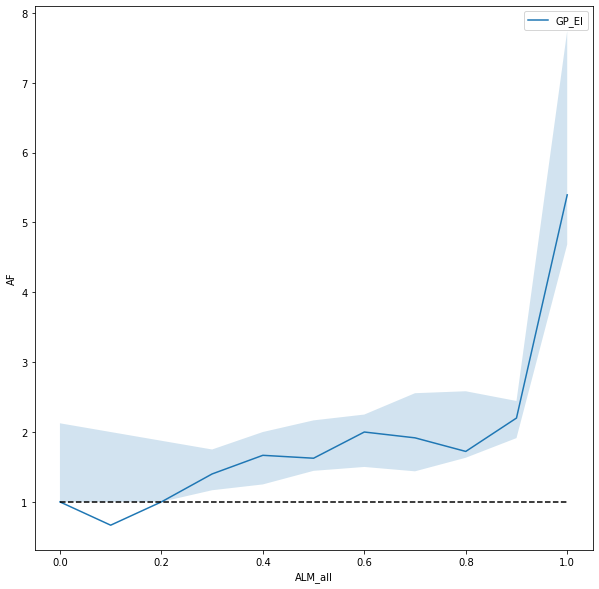

In [146]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


xx_GP_EI, f_med_GP_EI, f_low_GP_EI, f_high_GP_EI = AF_any_interp1d(ALM_any_GP_EI)
ax0.plot(xx_GP_EI, f_med_GP_EI(xx_GP_EI), label = 'GP_EI')
ax0.fill_between(xx_GP_EI, f_low_GP_EI(xx_GP_EI), f_high_GP_EI(xx_GP_EI), alpha=0.2)





ax0.plot(np.linspace(0, 1, 176), np.ones(176),'--',color='black',label=None)        
        

ax0.legend()
ax0.set_ylabel('AF')
ax0.set_xlabel('ALM_all')
# ax0.set_title('median')
# ax0.set_xlim([8, nn])
# ax0.set_ylim([0.95, 5])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [124]:
ARD_ = False

Bias_kernel = GPy.kern.Bias(X_feature.shape[1], variance=1.)

Matern52_kernel = GPy.kern.Matern52(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel

n_est = 50

In [137]:
def calc_MAE_GP(test_index, SL_model):
    SL_mae = 0
    
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]
        
        X_test = X_test.reshape([1,X_feature.shape[1]])
        
        SL_mean, SL_std = SL_model.predict(X_test)[0][0][0], SL_model.predict(X_test)[1][0][0]
        
        sl_mae = (y_test - SL_mean)**2 
        SL_mae += sl_mae       
    
    return SL_mae / len(test_index)

def GP_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        GP_train = GPy.models.GPRegression(X = np.array(X_train), 
                                           Y = np.array([[i] for i in y_train]), 
                                           kernel= Matern52_kernel,
                                           noise_var = 0.01
                                          )

        GP_train.optimize_restarts(num_restarts=10,
                                   parallel = True,
                                   robust = True,
                                   optimizer = 'bfgs',
                                   max_iters=100,
                                   verbose = False)
        
        total_mae += calc_MAE_GP(index_test, GP_train)
        
    return total_mae / len(seed_list)

def calc_MAE_RF(test_index, RF_model):
    RF_mae = 0
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]

        tree_predictions = []
        for j in np.arange(n_est):
            tree_predictions.append((RF_model.estimators_[j].predict(np.array([X_test]))).tolist())
        mean = np.mean(np.array(tree_predictions), axis=0)[0]

        std = np.std(np.array(tree_predictions), axis=0)[0]

        mae_ = (y_test - mean)**2 
        RF_mae += mae_
        
    return RF_mae / len(test_index)

def RF_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        RF_model = RandomForestRegressor(n_estimators= n_est)
        RF_model.fit(X_train, y_train)
        
        total_mae += calc_MAE_RF(index_test, RF_model)
        
    return total_mae / len(seed_list)

    

In [138]:
GP_MAE_full = GP_MAE_full()

In [139]:
GP_MAE_full

0.34454852754952

In [140]:
RF_MAE_full = RF_MAE_full()

In [141]:
RF_MAE_full

0.3282099902890576

Text(0.5, 0, 'n_eval')

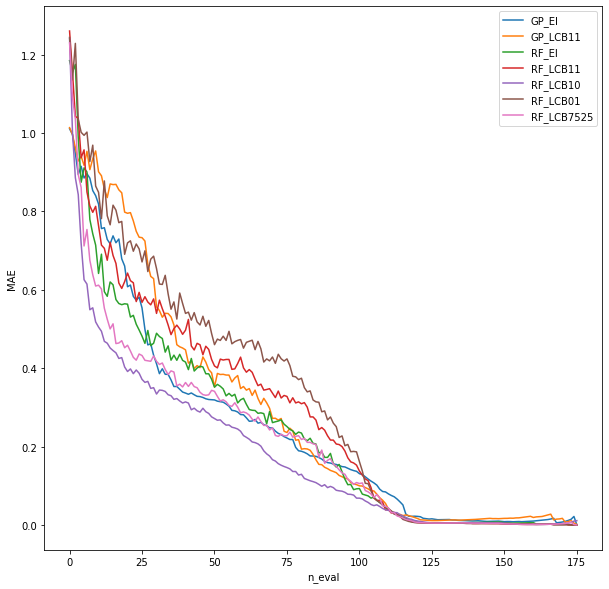

In [93]:
def average_run(x):
#     rows
    n_runs = len(x)
#     columns
    n_eval = len(x[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(n_runs):
            i_column.append(x[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        six_[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_), np.array(six_), np.array(nintyfour_)




# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

MAE = 4

i_ = MAE

MAE_GP_EI = average_run(x_GP_EI[i_])
MAE_GP_LCB11 = average_run(x_GP_LCB11[i_])


MAE_RF_EI = average_run(x_RF_EI[i_])
MAE_RF_LCB11 = average_run(x_RF_LCB11[i_])

MAE_RF_LCB10 = average_run(x_RF_LCB10[i_])
MAE_RF_LCB01 = average_run(x_RF_LCB01[i_])
MAE_RF_LCB7525 = average_run(x_RF_LCB7525[i_])


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(MAE_GP_EI[0], label = 'GP_EI')
# ax0.fill_between(np.arange(len(MAE_GP_EI[0])), MAE_GP_EI[1], MAE_GP_EI[2], alpha=0.2)

ax0.plot(MAE_GP_LCB11[0], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(MAE_GP_LCB[0])), MAE_GP_LCB[1], MAE_GP_LCB[2], alpha=0.2)


ax0.plot(MAE_RF_EI[0], label = 'RF_EI')
# # ax0.fill_between(np.arange(len(MAE_RF_EI[0])), MAE_RF_EI[1], MAE_RF_EI[2], alpha=0.2)

ax0.plot(MAE_RF_LCB11[0], label = 'RF_LCB11')
# ax0.fill_between(np.arange(len(MAE_RF_LCB11[0])), MAE_RF_LCB11[1], MAE_RF_LCB11[2], alpha=0.2)
# 
ax0.plot(MAE_RF_LCB10[0], label = 'RF_LCB10')
ax0.plot(MAE_RF_LCB01[0], label = 'RF_LCB01')
ax0.plot(MAE_RF_LCB7525[0], label = 'RF_LCB7525')
        

ax0.legend()
ax0.set_ylabel('MAE')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, int(math.ceil(len(y)*0.70))])
# ax0.set_ylim([0, 2])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [ ]:
def EF(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_EF = []
    
    for i in np.arange(len(l_avg_runs)):
        EF_i = []
        for j in np.arange(n_eval):
            EF_i.append(l_avg_runs[i][j] / ALM_ALL_RS[j])
        l_EF.append(EF_i)   
    
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_EF)):
            i_column.append(l_EF[j][i])
        
        i_column = np.array(i_column)
        median_[i] = np.median(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_)/ n_top, np.array(low_q)/ n_top, np.array(high_q)/ n_top
  

def AF(l_avg_runs):
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_ALM = []
    l_AF = []
    
    for i in np.arange(len(l_avg_runs)):
        ALM_i = []
        AF_i = []
        for j in np.arange(n_eval):
            n_eval_opt = j
            ALM = l_avg_runs[i][j]
            ALM_i.append(ALM)
            n_eval_rs = ALM * (n_eval - 1)
            AF = n_eval_rs / n_eval_opt
            AF_i.append(AF)
        l_ALM.append(ALM_i)
        l_AF.append(AF_i)
        
    ALM_median_ = [None for i in np.arange(n_eval)]
    ALM_low_q = [None for i in np.arange(n_eval)]
    ALM_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_ALM)):
            i_column.append(l_ALM[j][i])

        ALM_median_[i] = np.median(i_column)
        ALM_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        ALM_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
    
    AF_median_ = [None for i in np.arange(n_eval)]
    AF_low_q = [None for i in np.arange(n_eval)]
    AF_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_AF)):
            i_column.append(l_AF[j][i])

        AF_median_[i] = np.median(i_column)
        AF_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        AF_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
        
    return np.array(ALM_median_)/ n_top, np.array(ALM_low_q)/ n_top, np.array(ALM_high_q)/ n_top, np.array(AF_median_)/ n_top, np.array(AF_low_q)/ n_top, np.array(AF_high_q)/ n_top